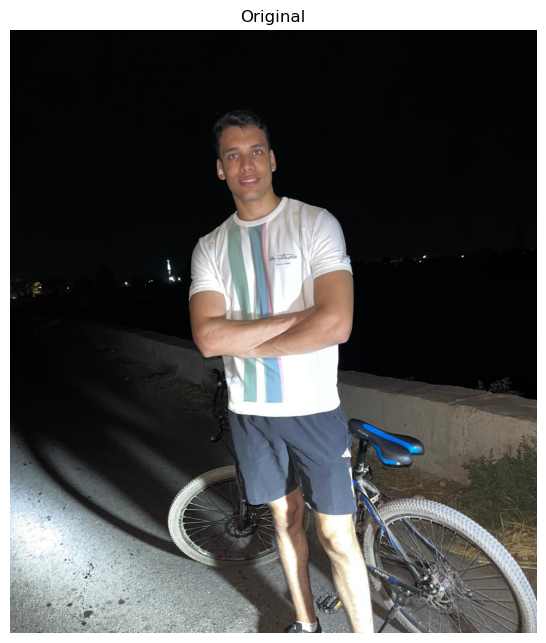

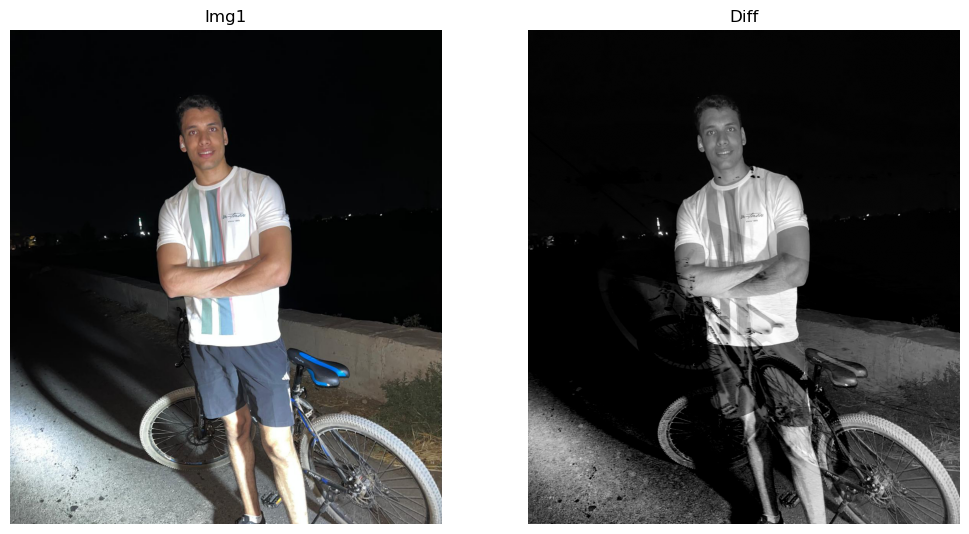

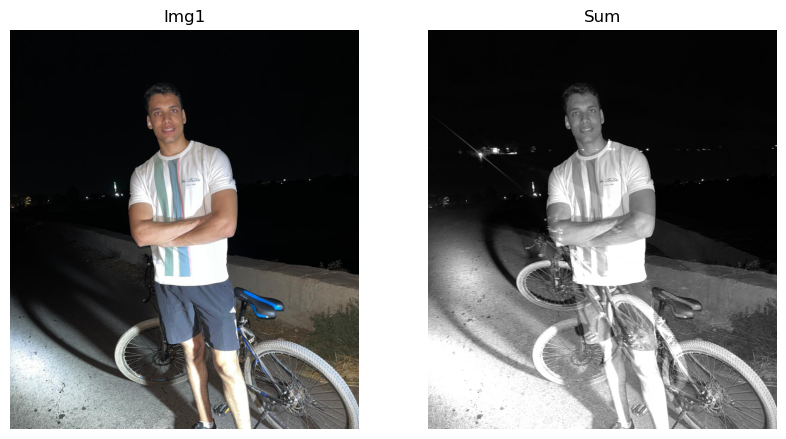

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from skimage import io, transform
import random
import math

class ImageProcessingApp:
    """
    ImageProcessingApp
    -----------------
    برنامج لمعالجة الصور يدوياً pixel-by-pixel.
    كل قسم في البرنامج مسؤول عن مجموعة من العمليات:
    
    1. Basic IO (رفع الصور)
    2. Color Conversion (RGB to Gray)
    3. Point Operations (Brightness, Darkness, Negative)
    4. Arithmetic Operations (Add/Subtract 2 images)
    5. Histogram Operations (Show, Stretch, Equalization)
    6. Linear Filters (Mean, Gaussian, Laplacian)
    7. Non-Linear Filters (Median, Min, Max, Range, Mode)
    8. Noise Addition (Salt&Pepper, Gaussian, Periodic)
    9. Morphology (Dilation, Erosion, Opening, Closing)
    10. Segmentation & Dithering (Auto Threshold, Floyd-Steinberg)
    """

    def __init__(self, root):
        # --- Main Window ---
        self.root = root
        self.root.title("CS303 Image Processing - Manual Pixel Operations")
        self.root.geometry("1300x850")

        # --- Images Storage ---
        self.original_image = None
        self.processed_image = None
        self.img2 = None

        # --- Layout Frames ---
        self.canvas_container = tk.Canvas(root, width=280, bg="#f0f0f0")
        self.scrollbar = tk.Scrollbar(root, orient="vertical", command=self.canvas_container.yview)
        self.btn_frame = tk.Frame(self.canvas_container, bg="#f0f0f0")

        self.btn_frame.bind(
            "<Configure>",
            lambda e: self.canvas_container.configure(scrollregion=self.canvas_container.bbox("all"))
        )

        self.canvas_container.create_window((0, 0), window=self.btn_frame, anchor="nw")
        self.canvas_container.configure(yscrollcommand=self.scrollbar.set)
        self.canvas_container.pack(side=tk.LEFT, fill=tk.Y)
        self.scrollbar.pack(side=tk.LEFT, fill=tk.Y)

        self.display_frame = tk.Frame(root, bg="white")
        self.display_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=5, pady=5)

        # --- Create Buttons ---
        self.create_buttons()

    # ------------------ Buttons Creation ------------------
    def create_buttons(self):
        self.add_label("Basic IO & Color")
        self.add_btn("Upload Image", self.upload_image)
        self.add_btn("Upload 2nd Image", self.upload_second_image_action)
        self.add_btn("RGB to Gray (Manual)", self.rgb_to_gray_manual)

        self.add_label("Point Operations")
        self.add_btn("Brightness (Add/Mult)", self.brightness_ops)
        self.add_btn("Darkness (Sub/Div)", self.darkness_ops)
        self.add_btn("Inverse (Negative)", self.negative_manual)

        self.add_label("Arithmetic Operations")
        self.add_btn("Add Two Images", self.add_images_manual)
        self.add_btn("Subtract Two Images", self.sub_images_manual)

        self.add_label("Histogram Operations")
        self.add_btn("Show Histogram", self.show_histogram_manual)
        self.add_btn("Contrast Stretching", self.contrast_stretching_manual)
        self.add_btn("Histogram Equalization", self.hist_equalization_manual)

        self.add_label("Linear Filters")
        self.add_btn("Mean Filter (3x3)", lambda: self.apply_convolution("mean"))
        self.add_btn("Gaussian Filter", lambda: self.apply_convolution("gaussian"))
        self.add_btn("Laplacian Filter", lambda: self.apply_convolution("laplacian"))

        self.add_label("Non-Linear Filters")
        self.add_btn("Median Filter", lambda: self.apply_nonlinear_filter("median"))
        self.add_btn("Min Filter", lambda: self.apply_nonlinear_filter("min"))
        self.add_btn("Max Filter", lambda: self.apply_nonlinear_filter("max"))
        self.add_btn("Range Filter", lambda: self.apply_nonlinear_filter("range"))
        self.add_btn("Mode Filter", lambda: self.apply_nonlinear_filter("mode"))

        self.add_label("Add Noise")
        self.add_btn("Salt & Pepper Noise", self.add_salt_pepper_noise)
        self.add_btn("Gaussian Noise", self.add_gaussian_noise)
        self.add_btn("Periodic Noise", self.add_periodic_noise)

        self.add_label("Morphology")
        self.add_btn("Dilation", lambda: self.apply_morphology("dilation"))
        self.add_btn("Erosion", lambda: self.apply_morphology("erosion"))
        self.add_btn("Opening", lambda: self.apply_morphology("opening"))
        self.add_btn("Closing", lambda: self.apply_morphology("closing"))

        self.add_label("Segmentation & Dithering")
        self.add_btn("Auto Thresholding", self.auto_thresholding_manual)
        self.add_btn("Floyd-Steinberg Dithering", self.dithering_manual)

    def add_label(self, text):
        tk.Label(self.btn_frame, text=text, font=("Arial", 10, "bold"), bg="#ddd", anchor="w").pack(fill=tk.X, pady=5)

    def add_btn(self, text, command):
        tk.Button(self.btn_frame, text=text, command=command, width=28, bg="#e1e1e1").pack(pady=1)

    # ------------------ Utility Functions ------------------
    def ensure_gray(self, img):
        """تحويل الصورة لـ grayscale يدوياً"""
        if len(img.shape) == 3:
            return ((img[:,:,0].astype(int) + img[:,:,1].astype(int) + img[:,:,2].astype(int)) // 3).astype(np.uint8)
        return img

    def display(self, img_in, img_out=None, title_in="Original", title_out="Processed"):
        """عرض الصورة الأصلية والمعالجة جنب بعض"""
        for widget in self.display_frame.winfo_children(): widget.destroy()
        cols = 2 if img_out is not None else 1
        fig, ax = plt.subplots(1, cols, figsize=(10,5))
        if cols == 1: ax = [ax]

        ax[0].imshow(img_in, cmap='gray' if len(img_in.shape)==2 else None)
        ax[0].set_title(title_in)
        ax[0].axis('off')

        if img_out is not None:
            ax[1].imshow(img_out, cmap='gray' if len(img_out.shape)==2 else None)
            ax[1].set_title(title_out)
            ax[1].axis('off')

        canvas = FigureCanvasTkAgg(fig, master=self.display_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=1)

    # ------------------ 1. Basic IO ------------------
    def upload_image(self):
        path = filedialog.askopenfilename()
        if path:
            self.original_image = io.imread(path)
            self.display(self.original_image)

    def upload_second_image_action(self):
        path = filedialog.askopenfilename()
        if path and self.original_image is not None:
            self.img2 = io.imread(path)
            self.img2 = transform.resize(self.img2, self.original_image.shape[:2], preserve_range=True).astype(np.uint8)
            messagebox.showinfo("Success", "Second image uploaded and resized")

    def rgb_to_gray_manual(self):
        if self.original_image is None: return
        self.processed_image = self.ensure_gray(self.original_image)
        self.display(self.original_image, self.processed_image, "RGB", "Gray")

    # ------------------ 2. Point Operations ------------------
    def brightness_ops(self):
        if self.original_image is None: return
        op = simpledialog.askstring("Input", "Type 'add' or 'mult':")
        val = simpledialog.askfloat("Value", "Enter value:")
        if not op or val is None: return

        img = self.ensure_gray(self.original_image).astype(float)
        res = img + val if op=='add' else img * val
        self.processed_image = np.clip(res,0,255).astype(np.uint8)
        self.display(self.original_image, self.processed_image, "Original", f"Brightness ({op})")

    def darkness_ops(self):
        if self.original_image is None: return
        op = simpledialog.askstring("Input", "Type 'sub' or 'div':")
        val = simpledialog.askfloat("Value", "Enter value:")
        if not op or val is None: return

        img = self.ensure_gray(self.original_image).astype(float)
        res = img - val if op=='sub' else np.where(val!=0,img/val,img)
        self.processed_image = np.clip(res,0,255).astype(np.uint8)
        self.display(self.original_image, self.processed_image, "Original", f"Darkness ({op})")

    def negative_manual(self):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image)
        self.processed_image = 255 - img
        self.display(self.original_image, self.processed_image, "Original", "Negative")

    # ------------------ 3. Arithmetic Operations ------------------
    def add_images_manual(self):
        if self.img2 is None: return
        res = np.clip(self.ensure_gray(self.original_image).astype(int)+self.ensure_gray(self.img2).astype(int),0,255)
        self.processed_image = res.astype(np.uint8)
        self.display(self.original_image, self.processed_image, "Img1","Sum")

    def sub_images_manual(self):
        if self.img2 is None: return
        res = np.clip(self.ensure_gray(self.original_image).astype(int)-self.ensure_gray(self.img2).astype(int),0,255)
        self.processed_image = res.astype(np.uint8)
        self.display(self.original_image, self.processed_image, "Img1","Diff")

    # ------------------ 4. Histogram Operations ------------------
    def compute_hist(self,img):
        hist = np.zeros(256,dtype=int)
        for p in img.flatten(): hist[p]+=1
        return hist

    def show_histogram_manual(self):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image)
        hist = self.compute_hist(img)
        plt.figure(); plt.bar(range(256),hist); plt.title("Histogram"); plt.show()

    def contrast_stretching_manual(self):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image)
        mn,mx = img.min(),img.max()
        res = ((img-mn)/(mx-mn)*255).astype(np.uint8)
        self.processed_image = res
        self.display(self.original_image,res,"Original","Contrast Stretched")

    def hist_equalization_manual(self):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image)
        hist = self.compute_hist(img)
        cdf = np.zeros(256)
        cdf[0]=hist[0]
        for i in range(1,256):
            cdf[i]=cdf[i-1]+hist[i]
        cdf_norm = np.round((cdf/img.size)*255).astype(np.uint8)
        h,w = img.shape
        eq_img = np.zeros_like(img)
        for i in range(h):
            for j in range(w):
                eq_img[i,j]=cdf_norm[img[i,j]]
        self.processed_image = eq_img
        self.display(self.original_image,eq_img,"Original","Equalized")

    # ------------------ 5. Linear Filters ------------------
    def apply_convolution(self,f_type):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image)
        if f_type=="mean":
            kernel = np.ones((3,3))/9
        elif f_type=="gaussian":
            kernel = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
        elif f_type=="laplacian":
            kernel = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
        h,w = img.shape
        padded = np.pad(img,1,mode='constant')
        out = np.zeros((h,w))
        for i in range(h):
            for j in range(w):
                region = padded[i:i+3,j:j+3]
                out[i,j]=np.sum(region*kernel)
        self.processed_image = np.clip(out,0,255).astype(np.uint8)
        self.display(self.original_image,self.processed_image,"Original",f"{f_type} Filter")

    # ------------------ 6. Non-Linear Filters ------------------
    def apply_nonlinear_filter(self,f_type):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image)
        h,w = img.shape
        padded = np.pad(img,1,mode='edge')
        out = np.zeros((h,w),dtype=np.uint8)
        for i in range(h):
            for j in range(w):
                region = padded[i:i+3,j:j+3].flatten()
                if f_type=="median":
                    val = np.median(region)
                elif f_type=="min":
                    val = np.min(region)
                elif f_type=="max":
                    val = np.max(region)
                elif f_type=="range":
                    val = np.max(region)-np.min(region)
                elif f_type=="mode":
                    counts = np.bincount(region)
                    val = np.argmax(counts)
                out[i,j]=val
        self.processed_image = out
        self.display(self.original_image,out,"Original",f"{f_type} Filter")

    # ------------------ 7. Noise ------------------
    def add_salt_pepper_noise(self):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image).copy()
        h,w = img.shape
        prob = 0.05
        for i in range(h):
            for j in range(w):
                r=random.random()
                if r<prob/2: img[i,j]=0
                elif r<prob: img[i,j]=255
        self.processed_image = img
        self.display(self.original_image,img,"Original","Salt & Pepper")

    def add_gaussian_noise(self):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image).astype(float)
        gauss = np.random.normal(0,25,img.shape)
        noisy = img+gauss
        self.processed_image = np.clip(noisy,0,255).astype(np.uint8)
        self.display(self.original_image,self.processed_image,"Original","Gaussian Noise")

    def add_periodic_noise(self):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image).astype(float)
        h,w = img.shape
        noisy = np.zeros_like(img)
        for i in range(h):
            for j in range(w):
                noise = 50*math.sin(i/2)
                noisy[i,j]=img[i,j]+noise
        self.processed_image = np.clip(noisy,0,255).astype(np.uint8)
        self.display(self.original_image,self.processed_image,"Original","Periodic Noise")

    # ------------------ 8. Morphology ------------------
    def _morph_op(self,op_type):
        img = self.ensure_gray(self.original_image)
        h,w = img.shape
        padded = np.pad(img,1,mode='edge')
        out = np.zeros((h,w),dtype=np.uint8)
        for i in range(h):
            for j in range(w):
                region = padded[i:i+3,j:j+3]
                if op_type=="dilation": out[i,j]=np.max(region)
                elif op_type=="erosion": out[i,j]=np.min(region)
        return out

    def apply_morphology(self,op):
        if op=="dilation": self.processed_image=self._morph_op("dilation")
        elif op=="erosion": self.processed_image=self._morph_op("erosion")
        elif op=="opening":
            eroded=self._morph_op("erosion")
            temp=self.original_image
            self.original_image=eroded
            self.processed_image=self._morph_op("dilation")
            self.original_image=temp
        elif op=="closing":
            dilated=self._morph_op("dilation")
            temp=self.original_image
            self.original_image=dilated
            self.processed_image=self._morph_op("erosion")
            self.original_image=temp
        self.display(self.original_image,self.processed_image,"Original",op.title())

    # ------------------ 9. Segmentation & Dithering ------------------
    def auto_thresholding_manual(self):
        if self.original_image is None: return
        img = self.ensure_gray(self.original_image)
        T = 128
        while True:
            g1 = img[img>T]; g2=img[img<=T]
            if len(g1)==0 or len(g2)==0: break
            new_T=(np.mean(g1)+np.mean(g2))/2
            if abs(T-new_T)<0.5: break
            T=new_T
        binary = np.zeros_like(img)
        binary[img>T]=255
        self.processed_image=binary
        self.display(self.original_image,binary,"Original",f"Auto Threshold T={int(T)}")

    def dithering_manual(self):
        if self.original_image is None: return
        img=self.ensure_gray(self.original_image).astype(float)
        h,w = img.shape
        for y in range(h):
            for x in range(w):
                old_pixel=img[y,x]
                new_pixel=255 if old_pixel>128 else 0
                img[y,x]=new_pixel
                quant_error=old_pixel-new_pixel
                if x+1<w: img[y,x+1]+=quant_error*7/16
                if x-1>=0 and y+1<h: img[y+1,x-1]+=quant_error*3/16
                if y+1<h: img[y+1,x]+=quant_error*5/16
                if x+1<w and y+1<h: img[y+1,x+1]+=quant_error*1/16
        self.processed_image=np.clip(img,0,255).astype(np.uint8)
        self.display(self.original_image,self.processed_image,"Original","Floyd-Steinberg Dithering")


# ------------------ Run the App ------------------
if __name__=="__main__":
    root=tk.Tk()
    app=ImageProcessingApp(root)
    root.mainloop()